### Impotar librerias y definir variables globales

In [80]:
#Importar Librerias
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from IPython.display import Image
NOW = "29/02/2020"

### Definir la ruta base y leer los datos

In [81]:
mainpath = "/Users/jeanpierrevasquez/Documents/Proyecto/05.Segmentation_Customers/"
dataname = "Summary_data_All_Countries_V1.csv"
dataoutput = "RFM_Segmento_1002_to_2802"

fullpathdata = os.path.join(mainpath,dataname)
fullpathoutput = os.path.join(mainpath,dataoutput)

In [82]:
print(fullpathdata)
print(fullpathoutput)
print(NOW)

/Users/jeanpierrevasquez/Documents/Proyecto/05.Segmentation_Customers/Summary_data_All_Countries_V1.csv
/Users/jeanpierrevasquez/Documents/Proyecto/05.Segmentation_Customers/RFM_Segmento_1002_to_2802
29/02/2020


# Funciones de Apoyo

### Defenir Funciones de resta y formato de fechas 

In [83]:
def days_between(d1, d2):
  #  d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%d/%m/%Y")
    return abs((d2 - d1).days)

In [84]:
def format_date(d):
    return d[0:2] + "/"+ d[3:5] + "/2020"

### Definir las fuciones de Scores en base a los quintiles

In [85]:
def r_score(x,quintiles):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
def fm_score(x, c,quintiles):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

### Definir función para hallar el Score en base a los quintiles

In [86]:
def rfm_table_score(rfm_table,quintiles): 
    rfm_table['R'] = rfm_table['Recency'].apply(lambda x: r_score(x,quintiles))
    rfm_table['F'] = rfm_table['Frequency'].apply(lambda x: fm_score(x, 'Frequency',quintiles))
    rfm_table['M'] = rfm_table['Monetary'].apply(lambda x: fm_score(x, 'Monetary',quintiles))
    rfm_table['RFM Score'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)
    return rfm_table

### Definir función para hallar los segmentos

In [87]:
def rfm_table_segment(rfm_table,segt_map,segt_other):
    rfm_table['Segment'] = rfm_table['RFM Score']
    rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
    rfm_table['Segment'] = rfm_table['Segment'].replace(segt_other, regex=True)
    return rfm_table

### Los Segmentos del RFM y las REGLAS son los siguientes : 

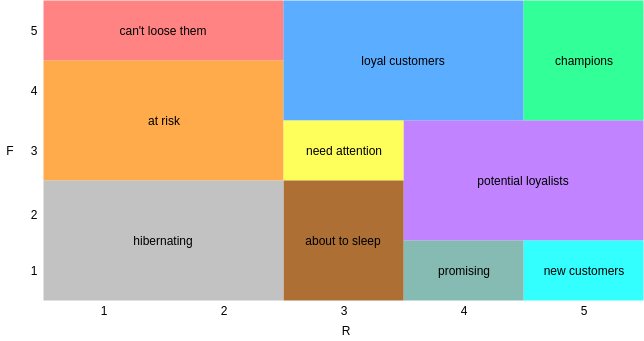

In [88]:
Image(filename=mainpath+'rfm-segments.png')

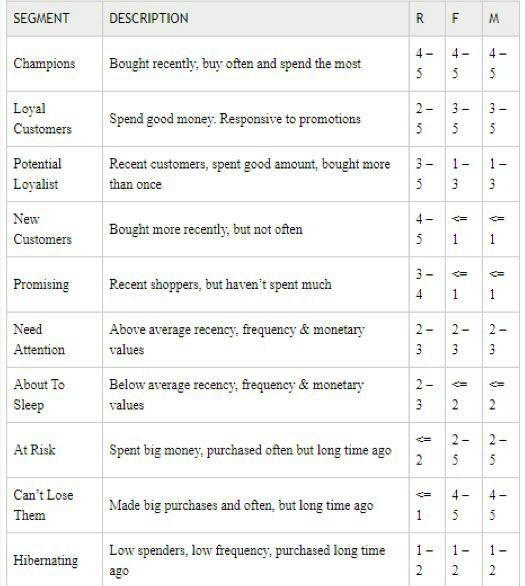

In [145]:
Image(filename=mainpath+'RFM_Rules.jpeg',width=400,height=60)

In [90]:
segt_map = {
    r'[4-5][4-5][4-5]': 'A. Champions',
    r'[2-5][3-5][3-5]': 'B. Loyal Customers',
    r'[3-5][1-3][1-3]': 'C. Potential Loyalist',
    r'[4-5]11': 'D. New Customers',
    r'[3-4]11': 'E. Promising',
    r'[2-3][2-3][2-3]': 'F. Need Attention',
    r'[2-3][1-2][1-2]': 'G. About to Sleep',
    r'[1-2][2-5][2-5]': 'H. At Risk',
    r'1[4-5][4-5]': 'I. Can\'t Lose Them',
    r'[1-2][1-2][1-2]': 'J. Hibernating',
    r'55[1-2]': 'K. Outlier',
    r'11[4-5]': 'K. Outlier'
}

segt_other={r'[0-9]+':'L. Others'}

# Lógica de Clustering

### Estructurar la data , leemos la data que descargamos del libro summary (todas las transacciones)

In [91]:
data_all = pd.read_csv(fullpathdata,sep=",")
data_all.head(10)

/Users/jeanpierrevasquez/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,16,22,31,33,34,35,43,54,63,66,67,68,71,87,94,99,128,130,142,143,144,147,149,151,153) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#Trips Out Of GeoFence,%Utilization over Scooters Deployed,Cabify Avg. Duration (mins),Blank 2,Blank 3,Blank 4,Cabify Fee,Cabify Avg. Ticket,%Utilization over Total Fleet,New Users w/Discount,...,trip_region,trips_order,type,updated_at,usd_xr,user_registration_date,vehicleid,zone_end,zone_final,zone_start
0,0,70%,75.6,NaN,NaN,NaN,1,11.5,304600%,0,...,Lima,13.0,kick,02/13/2020 19:30:38,0.294955,09/25/2019 07:45:48,movo-scooter:17737,PER-LIM-C,PER-LIM-D,PER-LIM-D
1,1,65%,NaN,NaN,NaN,NaN,0,NaN,314200%,0,...,Madrid,8.0,scooter,02/26/2020 13:45:02,1.090500,7/04/19 01:46,movo:20117,NaN,ES-MAD-K-A,ES-MAD-K-A
2,0,63%,NaN,NaN,NaN,NaN,0,NaN,304200%,0,...,Madrid,83.0,kick,2/10/20 15:23,1.090500,6/10/19 14:39,movo-scooter:10801,ES-MAD-K-G,ES-MAD-K-D,ES-MAD-K-D
3,0,65%,NaN,NaN,NaN,NaN,0,NaN,295000%,0,...,Buenos Aires,31.0,kick,2/11/20 09:30,0.016326,11/05/19 17:22,movo-scooter:19387,ARG-BUA-D,ARG-BUA-G,ARG-BUA-G
4,0,99%,NaN,NaN,NaN,NaN,0,NaN,295000%,0,...,Buenos Aires,28.0,kick,2/12/20 14:52,0.016326,07/23/2019 11:50:39,movo-scooter:19435,ARG-BUA-D,ARG-BUA-D,ARG-BUA-D
5,0,66%,NaN,NaN,NaN,NaN,0,NaN,344100%,0,...,Buenos Aires,31.0,kick,02/21/2020 14:24:35,0.016326,07/23/2019 11:50:39,movo-scooter:19487,ARG-BUA-J,ARG-BUA-J,ARG-BUA-J
6,0,66%,NaN,NaN,NaN,NaN,0,NaN,344100%,0,...,Buenos Aires,32.0,kick,02/21/2020 14:29:32,0.016326,07/23/2019 11:50:39,movo-scooter:19244,ARG-BUA-M,ARG-BUA-J,ARG-BUA-J
7,0,70%,NaN,NaN,NaN,NaN,0,NaN,304600%,0,...,Buenos Aires,30.0,kick,02/13/2020 19:05:26,0.016326,07/23/2019 11:50:39,movo-scooter:19361,ARG-BUA-M,ARG-BUA-J,ARG-BUA-J
8,0,99%,NaN,NaN,NaN,NaN,0,NaN,295000%,0,...,Buenos Aires,29.0,kick,2/12/20 19:13,0.016326,07/23/2019 11:50:39,movo-scooter:19421,ARG-BUA-M,ARG-BUA-G,ARG-BUA-G
9,0,66%,NaN,NaN,NaN,NaN,0,NaN,321400%,0,...,Barcelona,9.0,scooter,02/18/2020 15:06:57,1.090500,01/26/2020 14:05:49,movo:22589,ES-BCN-C,ES-BCN-F,ES-BCN-F


In [92]:
data_all.columns

Index(['#Trips Out Of GeoFence', '%Utilization over Scooters Deployed',
       'Cabify Avg. Duration (mins)', 'Blank 2', 'Blank 3', 'Blank 4',
       'Cabify Fee', 'Cabify Avg. Ticket', '%Utilization over Total Fleet',
       'New Users w/Discount',
       ...
       'trip_region', 'trips_order', 'type', 'updated_at', 'usd_xr',
       'user_registration_date', 'vehicleid', 'zone_end', 'zone_final',
       'zone_start'],
      dtype='object', length=154)

### Filtramos las columnas necesarias para el cluster
#### UserId -> Identificador único del usuario 
#### region_final -> Ciudad 
#### #Trips -> Variable de trip 
#### GMV - Rectifications -> GMV en dolares 
#### Time -> Fecha de la transacción
#### Active Users -> Identificador si el usuario es activo con nuestro producto
#### Type -> Tipo de Asset

In [93]:
columns_table = ["UserId", "region_final", "#Trips","GMV - Rectifications","Time","Active Users","type"]
row_filter = data_all["Active Users"]==1
data_reduce = data_all[row_filter][columns_table]
data_reduce.head(10)

,UserId,region_final,#Trips,GMV - Rectifications,Time,Active Users,type
0,2Hire:612637,Lima,1,11.503237,13/02/20,1,kick
1,2Hire:272638,Madrid,1,3.402360,26/02/20,1,scooter
2,2Hire:223137,Madrid,1,2.399100,10/02/20,1,kick
3,2Hire:756162,Buenos Aires,1,2.203939,11/02/20,1,kick
4,2Hire:334242,Buenos Aires,1,1.061167,12/02/20,1,kick
5,2Hire:334242,Buenos Aires,1,0.897910,21/02/20,1,kick
6,2Hire:334242,Buenos Aires,1,1.061167,21/02/20,1,kick
7,2Hire:334242,Buenos Aires,1,1.387680,13/02/20,1,kick
8,2Hire:334242,Buenos Aires,1,1.714192,12/02/20,1,kick
9,2Hire:910682,Barcelona,1,2.878920,18/02/20,1,scooter


In [94]:
data_reduce["Fecha"] = data_reduce["Time"].apply(lambda x: format_date(x))
data_reduce.head(5)

,UserId,region_final,#Trips,GMV - Rectifications,Time,Active Users,type,Fecha
0,2Hire:612637,Lima,1,11.503237,13/02/20,1,kick,13/02/2020
1,2Hire:272638,Madrid,1,3.402360,26/02/20,1,scooter,26/02/2020
2,2Hire:223137,Madrid,1,2.399100,10/02/20,1,kick,10/02/2020
3,2Hire:756162,Buenos Aires,1,2.203939,11/02/20,1,kick,11/02/2020
4,2Hire:334242,Buenos Aires,1,1.061167,12/02/20,1,kick,12/02/2020


In [95]:
data_reduce["Fecha_"] = data_reduce["Fecha"].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
data_reduce.head(5)

,UserId,region_final,#Trips,GMV - Rectifications,Time,Active Users,type,Fecha,Fecha_
0,2Hire:612637,Lima,1,11.503237,13/02/20,1,kick,13/02/2020,2020-02-13
1,2Hire:272638,Madrid,1,3.402360,26/02/20,1,scooter,26/02/2020,2020-02-26
2,2Hire:223137,Madrid,1,2.399100,10/02/20,1,kick,10/02/2020,2020-02-10
3,2Hire:756162,Buenos Aires,1,2.203939,11/02/20,1,kick,11/02/2020,2020-02-11
4,2Hire:334242,Buenos Aires,1,1.061167,12/02/20,1,kick,12/02/2020,2020-02-12


### Definirmos el RFM Table : Frequency,Monetary y Recency

In [96]:
rfm_table_global = data_reduce.groupby(['UserId','region_final',"type"]).agg({
        'Fecha_': lambda x: x.max(),
        '#Trips': 'count',
        'GMV - Rectifications': 'sum'}).reset_index()
rfm_table_global.rename(columns={ 'region_final':'Region',
                         'Fecha_':"Fecha",
                         '#Trips': 'Frequency',
                         'GMV - Rectifications': 'Monetary'}, inplace=True)
rfm_table_global["Recency"] = rfm_table_global["Fecha"].apply(lambda x: days_between(x,NOW))
rfm_table_global.head(10)

,UserId,Region,type,Fecha,Frequency,Monetary,Recency
0,2Hire:100008,Madrid,scooter,2020-02-17,1,2.093760,12
1,2Hire:100023,Madrid,scooter,2020-02-16,1,3.402360,13
2,2Hire:100035,Mexico City,kick,2020-02-16,2,2.662825,13
3,2Hire:10004,Madrid,scooter,2020-02-23,2,4.449240,6
4,2Hire:100072,Madrid,scooter,2020-02-28,3,7.851600,1
5,2Hire:100081,Barcelona,scooter,2020-02-19,2,6.019560,10
6,2Hire:100081,Madrid,scooter,2020-02-20,2,5.757840,9
7,2Hire:100083,Bogotá,kick,2020-02-14,1,2.931646,15
8,2Hire:10009,Madrid,scooter,2020-02-28,2,7.076800,1
9,2Hire:10012,Madrid,scooter,2020-02-23,1,1.046880,6


In [99]:
columns_table = ["Region", "type"]
data_type = rfm_table_global[columns_table]
data_type_asset = data_type.drop_duplicates(['Region','type']).reset_index()
data_type_asset.head(15)

,index,Region,type
0,0,Madrid,scooter
1,2,Mexico City,kick
2,5,Barcelona,scooter
3,7,Bogotá,kick
4,11,Lima,kick
5,47,Madrid,kick
6,155,Valencia,kick
7,271,Santiago de Chile,kick
8,446,Guadalajara,kick
9,1223,Buenos Aires,kick


In [98]:
columns_table = ["UserId", "Frequency", "Monetary","Recency","Fecha","Region","type"]
for index,dts in data_type_asset.iterrows():
    print("----------------------------------------Inicio----------------------------")
    print( dts["Region"] + " - " + dts["type"] )
    filter_region = rfm_table_global["Region"] == dts["Region"]
    filter_asset = rfm_table_global["type"] == dts["type"]
    rfm_table_regional = rfm_table_global[filter_region & filter_asset][columns_table]
    print(rfm_table_regional)
    print(rfm_table_regional.describe())
    quintiles_regional = rfm_table_regional[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
    print(quintiles_regional)
    rfm_table_regional = rfm_table_score(rfm_table_regional,quintiles_regional)
    rfm_table_regional = rfm_table_segment(rfm_table_regional,segt_map,segt_other)
    print(rfm_table_regional)
    rfm_table_regional.to_csv(mainpath +dataoutput+ "_" +dts["Region"] +"_"+ dts["type"] + ".csv")
    print("----------------------------------------Fin------------------------------")

----------------------------------------Inicio----------------------------
Madrid - scooter
             UserId  Frequency   Monetary  Recency      Fecha  Region     type
0      2Hire:100008          1   2.093760       12 2020-02-17  Madrid  scooter
1      2Hire:100023          1   3.402360       13 2020-02-16  Madrid  scooter
3       2Hire:10004          2   4.449240        6 2020-02-23  Madrid  scooter
4      2Hire:100072          3   7.851600        1 2020-02-28  Madrid  scooter
6      2Hire:100081          2   5.757840        9 2020-02-20  Madrid  scooter
...             ...        ...        ...      ...        ...     ...      ...
54444    2Hire:9967         10  16.750080        1 2020-02-28  Madrid  scooter
54445    2Hire:9968          2   2.617200       14 2020-02-15  Madrid  scooter
54447    2Hire:9972          1   3.401597       12 2020-02-17  Madrid  scooter
54452    2Hire:9989          2   4.974534        9 2020-02-20  Madrid  scooter
54453    2Hire:9990         13  17.0118

----------------------------------------Fin------------------------------
----------------------------------------Inicio----------------------------
Bogotá - kick
             UserId  Frequency   Monetary  Recency      Fecha  Region  type
7      2Hire:100083          1   2.931646       15 2020-02-14  Bogotá  kick
10     2Hire:100139          2   2.110785        8 2020-02-21  Bogotá  kick
15     2Hire:100291          1   2.110785        5 2020-02-24  Bogotá  kick
16     2Hire:100339          1   1.758988       12 2020-02-17  Bogotá  kick
17     2Hire:100378          6  17.003548        1 2020-02-28  Bogotá  kick
...             ...        ...        ...      ...        ...     ...   ...
54432   2Hire:99408          7  10.436660        1 2020-02-28  Bogotá  kick
54440   2Hire:99623          5   8.208609        5 2020-02-24  Bogotá  kick
54442   2Hire:99648          5  11.609319        2 2020-02-27  Bogotá  kick
54448   2Hire:99799          1   1.524456        3 2020-02-26  Bogotá  kick
5

----------------------------------------Fin------------------------------
----------------------------------------Inicio----------------------------
Valencia - kick
             UserId  Frequency  Monetary  Recency      Fecha    Region  type
155    2Hire:103087          2  13.52220        1 2020-02-28  Valencia  kick
1601   2Hire:145200          1   2.18100        1 2020-02-28  Valencia  kick
3968   2Hire:205520          1   2.18100        8 2020-02-21  Valencia  kick
4443    2Hire:21585          1   3.27150        9 2020-02-20  Valencia  kick
6654   2Hire:263557          1   2.17871        2 2020-02-27  Valencia  kick
...             ...        ...       ...      ...        ...       ...   ...
53796  2Hire:967683          2   6.32490        1 2020-02-28  Valencia  kick
53798  2Hire:967690          1   6.76110        1 2020-02-28  Valencia  kick
53921  2Hire:967976          1   6.54300        1 2020-02-28  Valencia  kick
54020  2Hire:968203          1   5.01630        1 2020-02-28  Val

             UserId  Frequency  Monetary  Recency      Fecha       Region  \
446    2Hire:109168          1  1.384669       14 2020-02-15  Guadalajara   
486    2Hire:110311          1  1.597695       14 2020-02-15  Guadalajara   
542    2Hire:112663          5  9.905666        1 2020-02-28  Guadalajara   
4530   2Hire:217286          1  6.603806       15 2020-02-14  Guadalajara   
5287   2Hire:232333          1  1.491182       18 2020-02-11  Guadalajara   
...             ...        ...       ...      ...        ...          ...   
54255  2Hire:968723          1  1.917106        1 2020-02-28  Guadalajara   
54278  2Hire:968799          2  7.668936        1 2020-02-28  Guadalajara   
54295  2Hire:968843          1  1.597695        1 2020-02-28  Guadalajara   
54302  2Hire:968858          1  4.367033        1 2020-02-28  Guadalajara   
54316  2Hire:968895          1  3.301903        1 2020-02-28  Guadalajara   

       type  R  F  M RFM Score                Segment  
446    kick  2  1  

# Análisis de una Región y Asset

### Antes de iniciar el análisis modifique las variabes de city y asset
#### City -> Mexico City, Barcelona, Bogotá, Lima, Madrid, Valencia, Santiago de Chile, Guadalajara, Buenos Aires, Santiago de Chile
#### Aseet -> kick, scooter, bike

In [143]:
city = "Madrid" ## Modifique aquí 
asset = "scooter" ## Modifique aquí

In [132]:
filter_region = rfm_table_global["Region"] == city
filter_asset = rfm_table_global["type"] == asset
columns_table = ["UserId","Recency", "Frequency", "Monetary","Fecha","Region","type"]
rfm_table_analysis = rfm_table_global[filter_region & filter_asset][columns_table]
rfm_table_analysis.shape

(8409, 7)

### Descripción general de los datos  e Histogramas 

In [133]:
rfm_table_analysis.describe()

,Recency,Frequency,Monetary
count,8409.000000,8409.000000,8409.000000
mean,7.422999,4.135569,11.106605
std,5.422475,5.738052,15.576649
min,1.000000,1.000000,-1.832040
25%,2.000000,1.000000,2.878920
50%,6.000000,2.000000,5.496120
75%,12.000000,5.000000,12.562560
max,19.000000,128.000000,191.055600


Text(0.5, 1.0, 'Histograma de Frequency de Madrid - scooter')

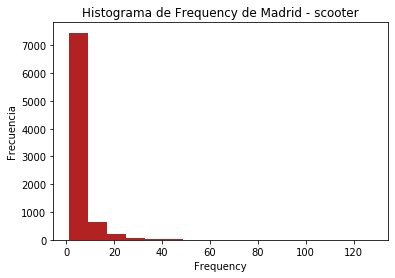

In [134]:
k = int(np.ceil(1+np.log2(18000)))
plt.hist(rfm_table_analysis["Frequency"],bins= k, color="firebrick")
plt.xlabel("Frequency")
plt.ylabel("Frecuencia")
plt.title("Histograma de Frequency de " + city +" - " + asset )

Text(0.5, 1.0, 'Histograma de Monetary Madrid - scooter')

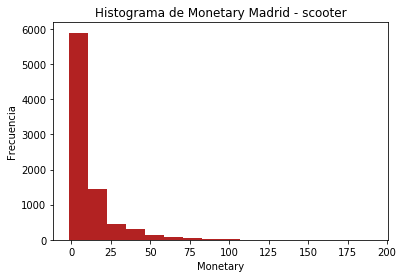

In [135]:
plt.hist(rfm_table_analysis["Monetary"],bins= k, color="firebrick")
plt.xlabel("Monetary")
plt.ylabel("Frecuencia")
plt.title("Histograma de Monetary " + city +" - " + asset )

Text(0.5, 1.0, 'Histograma de RecencyMadrid - scooter')

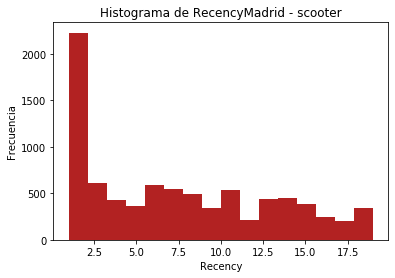

In [136]:
plt.hist(rfm_table_analysis["Recency"],bins= k, color="firebrick")
plt.xlabel("Recency")
plt.ylabel("Frecuencia")
plt.title("Histograma de Recency" + city +" - " + asset )

### Definimos los quintiles de las variles Frequency,Monetary y Recency 

In [137]:
quintiles_analysis = rfm_table_analysis[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles_analysis_df = pd.DataFrame(quintiles_analysis)
quintiles_analysis_df.head(15)

,Recency,Frequency,Monetary
0.2,2.0,1.0,2.612184
0.4,5.0,2.0,4.187520
0.6,8.0,3.0,7.328160
0.8,13.0,6.0,15.441480


### Hallamos el RFM & Score GLOBAL

In [138]:
rfm_table_analysis = rfm_table_score(rfm_table_analysis,quintiles_analysis)
rfm_table_analysis.head(5)

,UserId,Recency,Frequency,Monetary,Fecha,Region,type,R,F,M,RFM Score
0,2Hire:100008,12,1,2.09376,2020-02-17,Madrid,scooter,2,1,1,211
1,2Hire:100023,13,1,3.40236,2020-02-16,Madrid,scooter,2,1,2,212
3,2Hire:10004,6,2,4.44924,2020-02-23,Madrid,scooter,3,2,3,323
4,2Hire:100072,1,3,7.85160,2020-02-28,Madrid,scooter,5,3,4,534
6,2Hire:100081,9,2,5.75784,2020-02-20,Madrid,scooter,2,2,3,223


### Asignamos el Segmento GLOBAL segun las reglas 

In [139]:
rfm_table_analysis = rfm_table_segment(rfm_table_analysis,segt_map,segt_other)
rfm_table_analysis.head(5)

,UserId,Recency,Frequency,Monetary,Fecha,Region,type,R,F,M,RFM Score,Segment
0,2Hire:100008,12,1,2.09376,2020-02-17,Madrid,scooter,2,1,1,211,G. About to Sleep
1,2Hire:100023,13,1,3.40236,2020-02-16,Madrid,scooter,2,1,2,212,G. About to Sleep
3,2Hire:10004,6,2,4.44924,2020-02-23,Madrid,scooter,3,2,3,323,C. Potential Loyalist
4,2Hire:100072,1,3,7.85160,2020-02-28,Madrid,scooter,5,3,4,534,B. Loyal Customers
6,2Hire:100081,9,2,5.75784,2020-02-20,Madrid,scooter,2,2,3,223,F. Need Attention


### Escribimos el archivo con los resultados

In [140]:
rfm_table_analysis.to_csv(fullpathoutput+".csv")

### Distribución por Segmentos

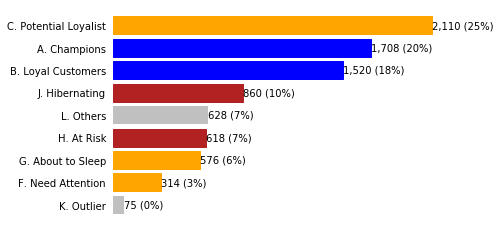

In [141]:
segments_counts = rfm_table_analysis['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['A. Champions', 'B. Loyal Customers']:
            bar.set_color('blue')
        if segments_counts.index[i] in ['C. Potential Loyalist', 'F. Need Attention',"G. About to Sleep"]:
            bar.set_color('orange')
        if segments_counts.index[i] in ['J. Hibernating', 'H. At Risk']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

### Distribución de Frequency,Monetary y Recency

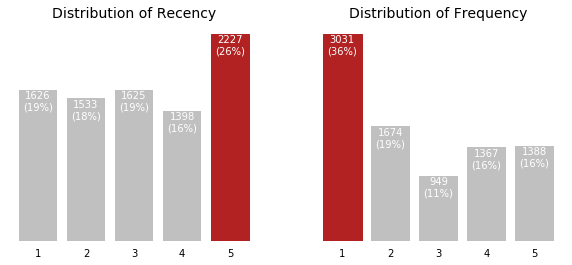

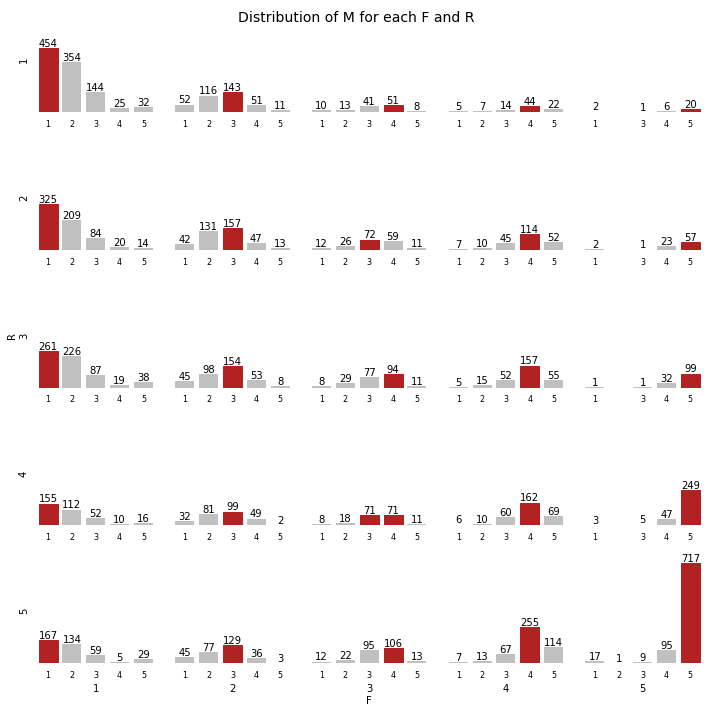

In [144]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm_table_analysis[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm_table_analysis[(rfm_table_analysis['R'] == r) & (rfm_table_analysis['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()